In [24]:
# coding: utf-8

from pulp import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# get_ipython().magic('matplotlib inline')
import seaborn as sn
import re

In [25]:
# generate locations of each sites
def generate_sites(num_customer_sites):
    sites = list(np.arange(0, num_customer_sites + 2))
    sdtlist = []

    # create distance matrix
    d_matrix = np.zeros((len(sites), len(sites)))

    # random generate points
    np.random.seed(234)
    positions = dict((a, (np.random.rand() - .5, np.random.rand() - .5)) for a in sites)
    # org
    positions[0] = (0, 0)
    # det
    positions[1] = (-0.1, 0.3)
    print(positions)

    # plot it
    for s in positions:
        p = positions[s]
        plt.plot(p[0], p[1], 'o')
        plt.text(p[0] + .01, p[1], s, horizontalalignment='left', verticalalignment='center')
    plt.gca().axis('off');
    plt.show()

    # a function for computing distance between two points
    d = lambda p1, p2: np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

    # calculate all the pairs
    for idx1, s1 in enumerate(positions):
        for idx2, s2 in enumerate(positions):
            if s1 != s2:
                d_matrix[idx1, idx2] = d(positions[s1], positions[s2])
    # print(d_matrix)
    for i in range(0,len(sites)):
        sdtlist.append(d(positions[i], positions[1]))
    return sites,d_matrix,positions,sdtlist

In [26]:
def visualize_result(non_zero_edges,sites,positions):
    # In[488]:

    def get_next_site(parent):
        '''helper function to get the next edge'''
        edges = [e for e in non_zero_edges if e[0]== parent]
        # print (edges)
#         for e in edges:
#             non_zero_edges.remove(e)
        return edges

    tours = get_next_site(0)
    # print (tours)
    tours = [ [e] for e in tours ]
    n = 1
    for t in tours:
        while n < len(sites)-1:
            if t[-1][1] != 0:
                # print (t[-1][1])
                t.append(get_next_site(t[-1][1])[-1])
                n +=1


    # Print he optimal tours:
    for t in tours:
        print(' -> '.join([ str(a) for a,b in t]+['1']))

    #draw the tours
    colors = [np.random.rand(3) for i in range(len(tours))]
    for t,c in zip(tours,colors):
        for a,b in t:
            p1,p2 = positions[a], positions[b]
            plt.plot([p1[0],p2[0]],[p1[1],p2[1]], color=c)

    #draw the map again
    for s in positions:
        p = positions[s]
        plt.plot(p[0],p[1],'o')
        plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')

    plt.gca().axis('off');
    plt.show()

#     return tours

In [27]:
def get_tours(non_zero_edges,sites,t_matrix):
    totaltime = []
    def get_next_site(parent):
        '''helper function to get the next edge'''
        edges = [e for e in non_zero_edges if e[0] == parent]
        # print (edges)
        # for e in edges:
        #     non_zero_edges.remove(e)
        return edges

    tours = get_next_site(0)
    # print (tours)
    tours = [[e] for e in tours]
    n = 1
    for t in tours:
        while n < len(sites) - 1:
            if t[-1][1] != 0:
                # print (t[-1][1])
                t.append(get_next_site(t[-1][1])[-1])
                n += 1
    return tours

{0: (0, 0), 1: (-0.1, 0.3), 2: (-0.25338022411111727, 0.19880741427740167), 3: (0.36642931919633603, 0.13952184711093762), 4: (-0.04315635161570486, -0.0012052480865952786), 5: (0.22047500693227895, -0.22874681031161803), 6: (0.3006190314201338, 0.009252675036787728)}


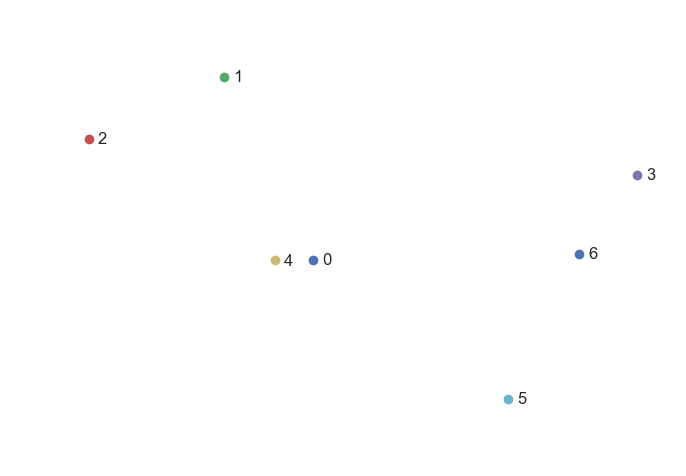

In [28]:
num_customer_sites = 5
K = 1  # the number of sales people(cars)
dist = 0
avgtime = 0
staytime = 1
M = 99999
speed = 0.05
sdtime = []
# geneate sites
sites, d_matrix, positions,sdtlist = generate_sites(num_customer_sites)
for a in range(2,len(sdtlist)):
    sdtime.append(sdtlist[a]/speed)
standardized_d_matrix = StandardScaler().fit_transform(d_matrix)
# compare all the feasilbe solution to find the one that minimize the whole objective function

t_matrix = d_matrix/speed
avg_t_matrix = t_matrix.mean()
std_t_matrix = t_matrix.std()
standardized_t_matrix = StandardScaler().fit_transform(t_matrix)
#generate indices for distance matrix
X,Y = np.meshgrid( np.arange(len(sites)), np.arange(len(sites)) )
matrix_coordinate_list = []
for coor in zip(X.flatten(),Y.flatten()):
    matrix_coordinate_list.append(coor)

In [29]:
#create the problme
prob=LpProblem("transpotation",LpMinimize)

#indicator variable if site i is connected to site j in the tour
x = LpVariable.dicts('x', (sites,sites), 0, 1, LpBinary)
#dummy vars to eliminate subtours
z = LpVariable.dicts('z', sites, 0, num_customer_sites, LpInteger)

s = LpVariable.dicts('s', sites, 0, None , LpContinuous)
s[0]=-0.3
u = LpVariable('u', 0, None, LpContinuous)

dist = sum([x[r][c] * standardized_d_matrix[r, c] for (r, c) in matrix_coordinate_list])
avgtime =  sum([s[1] - s[i] for i in range(0,len(s))])/num_customer_sites

#the objective
alpha = 0.5
beta = 0.5
gamma = 0.5
cost = lpSum(alpha*dist + beta*avgtime + gamma*u)
prob += cost

#add constraints
for (r,c) in matrix_coordinate_list:
    # (1) depot to destination or destination to depot is not allowed
    if (r == 0 and c == 1) or (r == 1 and c == 0):
        prob += (  lpSum([  x[r][c] ] ) == 0 )
    # (9) if A to B is visited, B to A is not allowed to be visited
    elif r != c :
        prob += ( lpSum( [ x[r][c] + x[c][r] ] ) <= 1 )
#
# (2) the diagonal value of x matrix is 0
prob += lpSum([ x[r][c] for (r,c) in matrix_coordinate_list if r==c ]) == 0
#
# (3) destination to other pickup nodes are not allowed
prob += lpSum([ x[r][c] for (r,c) in matrix_coordinate_list if r==1 ]) == 0
#
# (4) only one pickup node to destination is allowed
prob += lpSum([ x[r][c]  for (r,c) in matrix_coordinate_list if c== 1 and r != 0 and r!= 1 ]) == 1
#
# (5) pickup nodes to depot is not allowed
prob += lpSum([ x[r][c] for (r,c) in matrix_coordinate_list if c==0 ]) == 0
#
# (7) each node can be visited only once
for i in range(2, len(sites)):
    prob += lpSum([ x[r][c] for (r,c) in matrix_coordinate_list if r== i ]) == 1
#
# (6) each node can be visited only once
for i in range(2,len(sites)):
    prob += lpSum([ x[r][c] for (r,c) in matrix_coordinate_list if c== i  ]) == 1

# (8) subtour elimination
N=len(sites)/K
for i in sites:
    for j in sites:
        if i != j and (i != 0 and j!= 0 and i != 1 and j!= 1) and (i,j) in matrix_coordinate_list:
            prob += z[i] - z[j] <= (N)*(1-x[i][j]) - 1

# (9) start time is set correctly along the path
for (r, c) in matrix_coordinate_list:
    prob += s[c] - s[r] - standardized_t_matrix[r,c] + M*(1 - x[r][c])>= staytime

# (10) u constraint, the maximum difference between self-driving time and shuttle time
for i in range(2,len(sites)):
    prob += u + s[i] + sdtlist[i-2] - s[1]>= 0

In [30]:
# The problem data is written to an .lp file
# prob.writeLP("ovoc_nopdpd.lp")
result = prob.solve()
print(LpStatus[prob.status])

# # print solution
print(value(prob.objective))
# for v in prob.variables():
#     print(v.name, "=", v.varValue)

non_zero_edges = [ e for e in matrix_coordinate_list if value(x[e[0]][e[1]]) != 0 ]
print("The non zero edges are: ")
print (non_zero_edges)

totaltime = []
starttime = []
totaldist = 0
for a,b in non_zero_edges:
    totaldist += d_matrix[a,b]
optroute = get_tours(non_zero_edges, sites,t_matrix)
for t in optroute:
    for c,d in t:
        totaltime.append(t_matrix[c,d])
for i in range(1,len(totaltime))  :
    starttime.append(sum(totaltime[0:i]))

print("The optimal distance is: " ,totaldist)
print("The start time at each node is: ",starttime)

Optimal
1.93550692742
The non zero edges are: 
[(2, 1), (4, 2), (0, 3), (5, 4), (6, 5), (3, 6)]
The optimal distance is:  1.61134530458
The start time at each node is:  [7.8418567135070294, 10.760832641470193, 15.783454255217974, 22.748413860259756, 28.551831531697911]


0 -> 3 -> 6 -> 5 -> 4 -> 2 -> 1


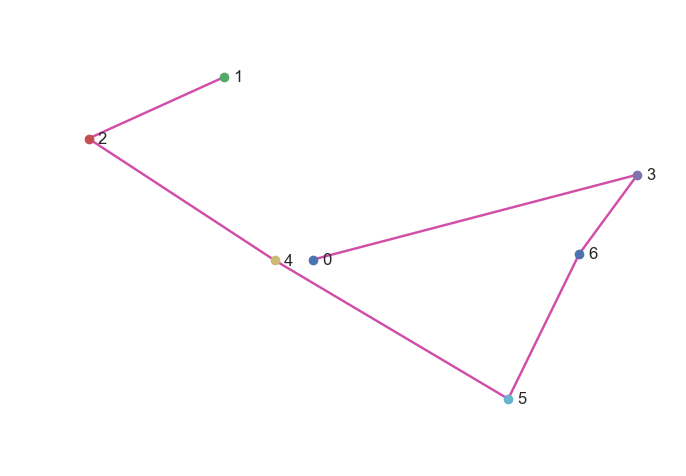

In [31]:
# see the result
visualize_result(non_zero_edges, sites, positions)